In [44]:
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.optimize as opt
from scipy.optimize import minimize
from sklearn.svm import SVC


In [45]:
 #Leemos el archivo csv
data=pd.read_csv("heart.csv")
#Parseamos las columnas que no tengan enteros a enteros
data.Sex=[1 if each == "M" else 0 for each in data.Sex]
data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
#guardamos data
valores=data.values
#la columna Y tendra los ataques al corazon
Y=data.HeartDisease.values
#Borramos la columna para asignar a X el resto de columnas
data.drop(['HeartDisease'], axis=1,inplace=True)
X=data.values

In [66]:

def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s
def cost(theta, X, Y,landa):
    H = sigmoid(np.matmul(X, theta))
    thetaAux=theta[1:]
    return (-1/(len(X))) * ( np.dot(Y, np.log(H)) + np.dot(1-Y, np.log(1-H))) + (landa/2*len(X))*sum(thetaAux*thetaAux)



    
def gradient(theta, X, Y,landa):
    H=sigmoid(np.matmul(X, theta))
    return (1/len(Y)) * np.matmul((X.T), H-Y) + (landa/len(X))*theta

def evaluaRl(thetas, X, y):
    thetasMat = np.matrix(thetas)   
    z = np.dot(thetasMat,X.transpose())
    resultados = sigmoid(z)
    resultados[resultados >= 0.5] = 1
    resultados[resultados < 0.5] = 0
    admitidosPred = sum(np.where(resultados == y)).shape[0]
    return (admitidosPred / len(y)) * 100

def RegresionLogistica():
    #Leemos el archivo csv
    data=pd.read_csv("heart.csv")
    #Parseamos las columnas que no tengan enteros a enteros
    data.Sex=[1 if each == "M" else 0 for each in data.Sex]
    data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
    data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
    data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
    data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
    #guardamos data
    valores=data.values
    #la columna Y tendra los ataques al corazon
    Y=data.HeartDisease.values
    #Borramos la columna para asignar a X el resto de columnas
    data.drop(['HeartDisease'], axis=1,inplace=True)
    X=data.values
    
    landa=1.0
    precision = 0.0
    #Vamos a separar los ejemplos en 80% para entrenar y un 20% para evaluar  
    X =  np.insert (X ,0, 1, axis = 1)
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,shuffle = True)
    theta = np.zeros((X.shape[1],1))
    result = opt.fmin_tnc(func=cost,x0=theta ,fprime=gradient,args =(x_train, y_train,landa))
    theta = result[0]
       
    precision = evaluaRl(theta,x_test,y_test)
    print(format((precision), '.2f' ),"%")
    return precision
    
RegresionLogistica()

68.48 %


68.47826086956522

In [47]:

def sigmoide(values): 
    return 1/(1+np.exp(-(values)))


def dSigmoide(values): 
    return sigmoide(values) * (1 - sigmoide(values))


def forward_propagate(X, theta1, theta2):     
    a = np.insert(X, 0, 1, axis=1) 
    aa = np.dot(a,theta1.T)
    afs = sigmoide(aa)
    aadd = np.insert(afs, 0, 1, axis = 1)
    a2dot = np.dot(aadd,theta2.T)
    a2fs = sigmoide(a2dot) 
    return a2fs

#Inicializa un vector de thetas para una capa con L_in entradas y L_out salidas entre un rango range
def randomizeThetas(L_in, L_out, range = 0.12):
    # Inicializamos los vectores de theta
    W = np.zeros((L_out, 1 + L_in))
    # Randomizamos el vector entre -rango y rango
    W = np.random.rand(L_out, 1 + L_in) * (2 * range) - range
    return W

def coste(theta1, theta2, X, y):
    J = np.sum(-y * np.log(forward_propagate(X, theta1, theta2))-(1-y)*np.log(1-forward_propagate(X, theta1, theta2)))/len(y)
    return J

def costeReg(theta1, theta2, X, y, reg):
    thetaAux1 = np.delete(theta1, 0, 1)
    thetaAux2 = np.delete(theta2, 0, 1)
    regularized = (reg / (2*len(X))) * (sum(sum(np.power(thetaAux1, 2))) + sum(sum(np.power(thetaAux2, 2))))
    return coste(theta1, theta2, X, y) + regularized 

def gradiente(theta1, theta2, X, y, reg):
    
    a1 = np.insert(X, 0, 1, axis=1) 
    z2 = np.dot(a1, theta1.T)

    a2 = sigmoide(z2)
    a2 = np.insert(a2, 0, 1, axis = 1)
    z3 = np.dot(a2,theta2.T)
    a3 = sigmoide(z3)
    
    d3 = np.max(a3) - y
    d2 = np.delete(np.dot(d3, theta2), 0, 1) * dSigmoide(z2)

    A1 = np.dot(d2.T, a1)
    A2 = np.dot(d3.T, a2)
    
    A1 = A1 / len(X)
    A2 = A2 / len(X)
    return A1, A2

def gradienteReg(theta1, theta2, X, y, reg):
    A1, A2 = gradiente(theta1, theta2, X ,y, reg)
    reg1 = (reg / len(y)) * theta1
    reg2 = (reg / len(y)) * theta2
    
    reg1[:,:1]=0
    reg2[:,:1]=0
    
    A1reg = A1.copy()
    A2reg = A2.copy()
    A1reg += reg1
    A2reg += reg2
    
    return A1reg,A2reg
     

def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    thetaAux1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    thetaAux2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    costt = costeReg(thetaAux1, thetaAux2, X, y, reg)
    gradd1 ,gradd2 = gradienteReg(thetaAux1, thetaAux2, X, y, reg)
    gradd = np.concatenate((np.ravel(gradd1),np.ravel(gradd2)))
    return costt



def unroll_thetas(params, n_entries, n_hidden, n_et):
    theta1 = np.reshape(params[:n_hidden * (n_entries + 1)], (n_hidden, (n_entries + 1)))
    theta2 = np.reshape(params[n_hidden * (n_entries + 1):], (n_et, (n_hidden + 1)))
    return theta1, theta2


def RedesNeuronales():
    #Leemos el archivo csv
    data=pd.read_csv("heart.csv")
    #Parseamos las columnas que no tengan enteros a enteros
    data.Sex=[1 if each == "M" else 0 for each in data.Sex]
    data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
    data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
    data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
    data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
    #guardamos data
    valores=data.values
    #la columna Y tendra los ataques al corazon
    Y=data.HeartDisease.values
    #Borramos la columna para asignar a X el resto de columnas
    data.drop(['HeartDisease'], axis=1,inplace=True)
    X=data.values
    
    ######
    num_entradas = 11
    #Las unidades de la capa oculta
    num_ocultas = 10
    #Las etiquetas de la salida
    num_etiquetas = 2

    #Creación de casos de entrenamiento aleatorios para las redes neuronales
    X_Train, X_test, Y_Train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    Y_Train = np.expand_dims(Y_Train, axis = 1)
    
    m=len(Y_Train)
    #Creación de las etiquetas necesarias
    y_onehot = np.zeros((m, num_etiquetas))
    for i in range(m):
        y_onehot[i][Y_Train[i]] = 1

    #Inicializamos theta con pesos aleatorios
    theta1 = randomizeThetas(X_Train.shape[1], num_ocultas)
    theta2 = randomizeThetas(num_ocultas, num_etiquetas)
    thetaVec = np.append(theta1, theta2).reshape(-1)
    
    #Obtención de las thetas óptimas
    result = opt.minimize(fun=backprop, x0=thetaVec, args=(num_entradas, num_ocultas, num_etiquetas, X_Train, y_onehot, 1))
    thetas_opt = result.x

    #Reestablecemos theta para la evalución de resultados
    theta1, theta2 = unroll_thetas(thetas_opt, num_entradas, num_ocultas, num_etiquetas)
    pred = evalua(forward_propagate(X_test, theta1, theta2), Y_test)
    print(format(pred, '.2f' ),"%")
    return pred


def evalua(results, Y):
    numAciertos = 0
    for i in range(results.shape[0]):
        result = np.argmax(results[i])
        if result == Y[i]: numAciertos += 1  
    return (numAciertos/(results.shape[0]))*100

RedesNeuronales()

<ipython-input-47-1611efdb4f72>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-(values)))


85.81 %


85.8085808580858

In [48]:

def SVM():
    #Leemos el archivo csv
    data=pd.read_csv("heart.csv")
    #Parseamos las columnas que no tengan enteros a enteros
    data.Sex=[1 if each == "M" else 0 for each in data.Sex]
    data.ExerciseAngina=[1 if each == "N" else 0 for each in data.ExerciseAngina]
    data.ChestPainType=[0 if each == "ASY"  else 1 if each=="NAP" else 2  for each in data.ChestPainType]
    data.RestingECG=[0 if each == "Normal"  else 1 if each=="LVH" else 2  for each in data.RestingECG]
    data.ST_Slope=[0 if each == "Flat"  else 1 if each=="Up" else 2  for each in data.ST_Slope]
    #guardamos data
    valores=data.values
    #la columna Y tendra los ataques al corazon
    Y=data.HeartDisease.values
    #Borramos la columna para asignar a X el resto de columnas
    data.drop(['HeartDisease'], axis=1,inplace=True)
    X=data.values

    precision=0
    numIter = 1
    #Parametro de regulalizacion
    C_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    #copiamos sigma
    sigma_vec = np.copy(C_vec)

    #for con iteraciones  para probar
    for x in range(0, numIter):
        #variables para guardar los mejores parametros
        bestC = 0.01
        bestSigma = 0.01
        bestScore = -1
        #Vamos a separar los ejemplos en 80% para entrenar y un 20% para evaluar
        X_new, Xval, y_new, Yval = train_test_split(X, Y, test_size = 0.20,shuffle = True)
        #recorremos el vector de seleccion de C y sigma quedandonos con los mejores parametros (C,Sigma,Score)
        for c in  C_vec:
            for sigma in sigma_vec:
                auxKernel = SVC(C = c, kernel = 'rbf', gamma =  1/(2*sigma **2))
                auxKernel.fit(X_new, y_new.flatten())
                score = auxKernel.score(Xval,Yval)
                if (score > bestScore):
                    bestC = c
                    bestSigma = sigma   
                    bestScore = score
        #Calculo del SVM
        svm = SVC(kernel = 'rbf', C = bestC, gamma = 1 / (2 * bestSigma **2))
        #Modelos el svm con X, y en nuestro caso son el 80% de la muestra
        svm.fit(X_new, y_new.flatten())
        #Calculamos la precision del SVM para un conjunto de prueba, el 20% de la muestra en nuestro caso
        precision += test(svm, Xval, Yval)
    #imprimimos la media de precicion del numero de iteraciones
    print(format((precision / numIter)* 100, '.2f' ),"%")
    return precision / numIter * 100
       
    

def test(svm, X, Y):
    prediction = svm.predict(X)
    accuracy = np.mean((prediction == Y).astype(int))
    return accuracy

SVM()

82.61 %


82.6086956521739

In [68]:
print("Precision Regresion Logistica")
log=RegresionLogistica()
print("Precision Redes Neuronales")
red=RedesNeuronales()
print("Precision SVM")
sv=SVM()


Precision Regresion Logistica
81.52 %
Precision Redes Neuronales
83.50 %
Precision SVM
78.26 %


78.26086956521739


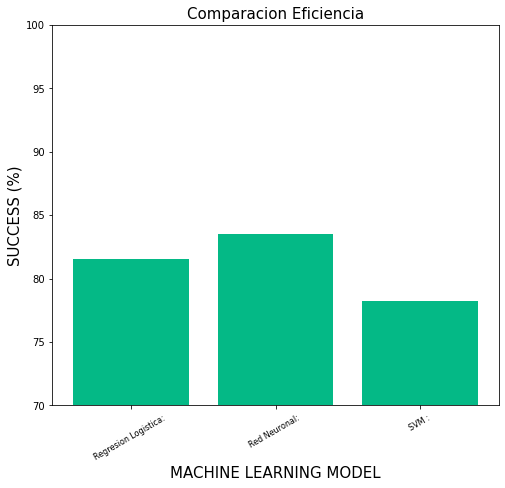

In [71]:

xBars = ['Regresion Logistica: ', 
         'Red Neuronal: ', 
         'SVM : ']   
ancho = 0.8
fig, ax = plt.subplots(figsize=(8,7))
index = np.arange(len(xBars))
print(sv)
plt.bar(index, [float(log),float(red),float(sv)], ancho, color='#04B986')
plt.xlabel('MACHINE LEARNING MODEL', fontsize=15)
plt.ylabel('SUCCESS (%)', fontsize=15)
plt.xticks(index, xBars, fontsize=8, rotation=30)
plt.title('Comparacion Eficiencia', fontsize=15)
plt.ylim((0, 100))
plt.savefig('ComparaciondeEficiencia.png')